<h1>Tutorial: Path integral approximations to real time correlations</h1>
<h2><em>Mariana Rossi, MPSD Hamburg</em></h2>

In this exercise, we will start with the simple example of a 3D Morse oscillator in order to showcase some of the approximations to real-time quantum correlations that can be used in i-PI. A second part of the exercise will deal with Ice Ih  using a  simple empirical force field model based on TIP4P-like point charges.


<h3> Understanding methods and limitations with the Morse oscillator </h3>

In this part of the exercise, we will be dealing with a simple potential, namely the Morse oscillator defined by the following potential
$$
V(r) = D\{\exp[-2 a (r-r_0)]- 2 \exp[-a (r-r_0)]\},
$$
where $D$ is 5.101744 eV, $a$ is 2.1930272 $\mathring{A}$$^{-1}$ and $r_0$ is 0.96966 $\mathring{A}$. These parameters are very close to those that describe an OH radical, as tabulated in books such as [1]. To avoid any conversion problems, the values of these quantities in atomic units are $D=0.18748563$, $a=1.1605$ and $r_0=1.8323918$. The fundamental vibrational excitation in this potential lies at $3568$ cm$^{−1}$.

[1]: K. P. Huber and G. Herzberg, Molecular Spectra and Molecular Structure IV. Constants of Diatomic Molecules (Van Nostrand Reinhold, New York, 1979), p. 508.

In [1]:
import argparse
import itertools
import sys
import os
import csv
import numpy as np
from ipi.utils.io import read_file_raw
from ipi.utils.units import unit_to_internal, unit_to_user
from ipi.utils.messages import verbosity
from matplotlib import pyplot as plt

#### The potential
Let us plot this potential, to visualize it

[]

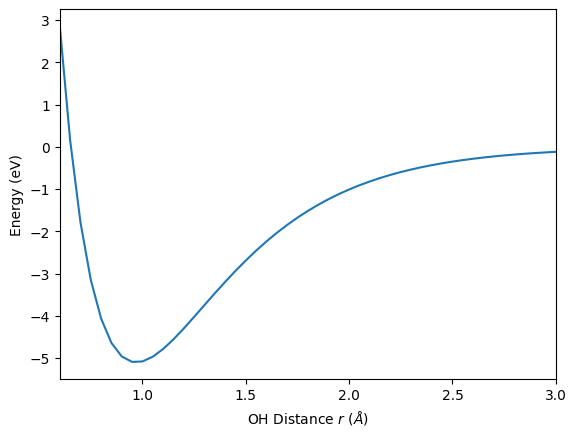

In [2]:
r0=0.96966 # A
def VmorseOH(r, r0):
    hbar=6.582119569e-16 # eV s
    c=2.99792458e10 # cm/s
    hc=hbar*c*2*np.pi # eV*cm
    #mo=15.9994*1836.1527 # atomic units
    #mh=1.00784*1836.1527 # atomic units
    #muoh=mo*mh/(mo+mh) # atomic units
    we=3737.76 # cm-1
    xe=84.881 # cm-1
    D=hc*we**2/(4*xe) # eV3
    a=2.1930272 # 1/A
    return D*(np.exp(-2*a*(r-r0)) - 2*np.exp(-a*(r-r0)))

grid=np.arange(0.6, 5, 0.05)
pot=[VmorseOH(i, r0) for i in grid]
plt.plot(grid,pot)
plt.xlim([0.6,3])
plt.ylabel('Energy (eV)')
plt.xlabel(r'OH Distance $r$ ($\AA$)')
plt.plot()

#### Vibrational Spectra
We will now run: Classical simulations, RPMD simulations, two flavors of TRPMD simulations, and partially-adiabatic CMD simulations (PA-CMD) with two different protocols for the adiabatic separation of the internal modes. The goal will be to compare these spectra and understand limitations of the methodology.

<div class="alert alert-block alert-info">
<b>Attention:</b> The PI simulations of this exercise will be run at 109 K, but using 32 beads. Reaching convergence wrt. the number of beads for this quantity requires many more beads at this temperature. These settings are only sufficient for the pedagogical purposes of this exercise. Do not use them for production calculations. 

In addition, we will only perform short/few simulations, which also do not represent statistical convergence. </div>

#### 1. Classical spectrum

We provide you with several i-PI checkpoints from a classical NVT simulation in the folder `./class-therm`. As discussed in the lectures, from these checkpoints we can start several classical NVE simulations from which we can extract the vibrational density of states (VDOS) from the velocity autocorrelation function. 

$$
I(\omega) \propto \int e^{i\omega t}\sum_i^{3N} \langle v_i(0) v_i(t) \rangle dt
$$

<div>
<img src="./images/fig1.png" width="500"/>
</div>

The idea is to start many NVE trajectories from these pre-thermalized checkpoints, like in the drawing above.
An input for the NVE simulations is found in `./nve`. <span style="color:blue">Read the input carefully! </span>

<div class="alert alert-block alert-warning">
<b>Question:</b> Can you understand all entries of the input? If not, ASK US!
</div>


1. Make several different folders and add different thermalized checkpoints to each of them
2. Enter one of the folders and copy the file `nve.xml` there. Make sure this file is referencing to the right checkpoint file to initialize.
3. Start one simulation inside a given folder. Run:

`$ i-pi nve.xml &> log.ipi &` <br>
`$ i-pi-driver -u -a oh-nve -m morsedia > out &` <br>

<div class="alert alert-block alert-success">
    <b>Note 1:</b> The reason why no parameters are needed for the potential in <samp>i-pi-driver</samp> is that the default parameters for this option are those of this Morse potential. If you want to change the parameters of the Morse potential, this is possible through the <samp>-o</samp> option.
</div>

<div class="alert alert-block alert-success">
    <b>Note 2:</b> Around 10 trajectories should give a reasonably converged result. However, a single one is already fine to see qualitative results.
</div>

You can watch the trajectory to see how the OH molecule is moving, if you are using your computer. Programs like Ovito and VMD can easily do this.

When the simulation is done, build the velocity autocorrelation function and its Fourier transform. This can be easily achieved with the `i-pi-getacf` script. At a folder where you have run your trajectory, type: 

`$  i-pi-getacf -ifile simulation.vel_0.xyz -mlag 1024 -ftpad 3072 -ftwin cosine-hanning -dt "1.0 femtosecond" -oprefix nve`

This computes the autocorrelation of the system velocity `acf` and its Fourier transform `facf`, which gives you the VDOS. Note that to smoothen the VDOS we have used a "cosine hanning" window function (see [Wikipedia](https://en.wikipedia.org/wiki/Hann_function)). Read the help function of the script for more details `i-pi-getacf -h`. Feel free to increase `mlag`, and play with different window functions to see how they affect the spectrum. 

Note that units of time and frequency are atomic units. We will convert them before plotting below. 

If you have many trajectories, run the script above for each trajectory in each directory and average the VDOS.

#### 2. RPMD spectrum

We provide you with several i-PI checkpoints from a quantum PIMD simulation in the folder `./pimd-therm`. As discussed in the lectures, from these checkpoints we can start several RPMD simulations from which we can extract the vibrational spectra. In this case the spectra can be calculated from the centroid velocities.

<div class="alert alert-block alert-warning">
<b>Question:</b> Can you show why the centroid velocities are all that is needed, based on the RPMD formulation for the velocity autocorrelation function?
</div>

<div>
<img src="./images/fig2.png" width="500"/>
</div>

Similar to the classical-nuclei simulations, the idea is to start many RPMD trajectories from pre-thermalized PIMD checkpoints, like in the drawing above.
An input for the RPMD simulations is found in `./rmpd`.

1. Make several different folders and add different thermalized checkpoints to each of them
2. Enter one of the folders and copy the file `rpmd.xml` there. Make sure this file is referencing to the right checkpoint file to initialize.
3. Start one simulation inside a given folder. Run:

`$ i-pi rpmd.xml &> log.ipi &` <br>
`$ for i in {1..32}; do i-pi-driver -u -a oh-rpmd -m morsedia > out & ; done ` <br>

**Notes 1 and 2 also apply here.**

When the simulation is done, build the centroid velocity autocorrelation function and its Fourier transform. This can be easily achieved with the `i-pi-getacf` script again. The command is: 

`$  i-pi-getacf -ifile simulation.vc.xyz -mlag 1024 -ftpad 3072 -ftwin cosine-hanning -dt "1.0 femtosecond" -oprefix rpmd`

#### 3. TRPMD, TRPMD-GLE, CMD spectra

In the directories `./trpmd`, `./trpmd-gle`, `./cmd`, corresponding input files for these methods. 

The TRPMD-GLE setting corresponds to the one discussed in [this paper](https://pubs.aip.org/aip/jcp/article/148/10/102301/197471/Fine-tuning-classical-and-quantum-molecular).

In the CMD directory, you will have an optional directory input that just runs a different type of scaling of the internal modes of the ring polymer. A discussion about these options can be found in [this paper](https://doi.org/10.1063/5.0129482).

<div class="alert alert-block alert-warning">
<b>Question:</b> Look at the thermostat options used for the CMD run. These are underdamped (weakly coupled) Langevin thermostats in the internal modes of the ring polymer. Can you guess why that is?

<details>
    <summary>Click once on <font color="blue"><b>this text</b></font> to see an explanation!</summary>
  
  #### Answer
  There is a neat reason why this leads to a much more effective adiabatic separation for CMD, rooted in how stronger Langevin thermostats broaden the internal RP modes so much that they end up interacting with the physical system. Check out the discussion in the supplementary material of [this paper](https://doi.org/10.1063/1.4901214), Figs. S1 and S2. 
</details>

</div>

#### Plotting and Analysing

Let us now plot everything and try to make sense of what we got. You should try plotting your own trajectories, but just in case they are not available, we provide some pre-computed simulations in the directory `./precomputed`. For reference, you should be seeing something like this:

[]

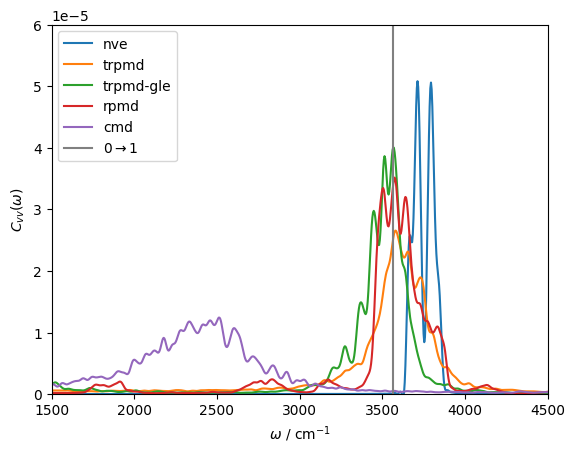

In [9]:
methods = ['nve', 'trpmd', 'trpmd-gle','rpmd', 'cmd'] 
for mm in methods:
    velFT = np.loadtxt('./precomputed/'+ mm + '_facf_avg.dat', usecols=(0,1))
    plt.plot(velFT[:,0]* 219474.63,velFT[:,1], label = '%s'%mm) # Here we have converted from atomic units of frequency (1/Ha) to cm-1!
plt.axvline(x = 3568, color = 'gray', label = r'$0\rightarrow1$')
plt.xlim([1500,4500])
plt.ylim([0,6e-5])
plt.ylabel(r'$C_{vv}(\omega)$')
plt.xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')
plt.legend()
plt.plot()

In the plot above, simulations are not fully converged. More statistics would be needed for that, and that would remove some of the noise. Nevertheless, the qualitative features we may want to look at are alredy clear. Think about these questions: 

<div class="alert alert-block alert-warning">
<b>Question:</b> Why is the NVE peak blue-shifted with respect to the true (quantum) fundamental vibrational transition in this potential?
</div>

<div class="alert alert-block alert-warning">
<b>Question:</b> Can you spot the spurious resonances of RPMD? Can you calculate, for this temperature the first Matsubara frequency of the ring polymer, $\omega_M = 2 \pi / (\beta \hbar)$? What is its value? How do the resonances relate to it?
</div>


<div class="alert alert-block alert-warning">
<b>Question:</b> Can you see that the TRPMD spectra do not show the spurious resonances? The TRPMD-GLE peak is narrower than the TRPMD peak - as expected. In this case it is also slightly red-shifted. Look at the full range of the spectra, including the rotational bands. Can you see the differences between the methods also there? Check out <a href="https://doi.org/10.1063/1.4990536">this reference</a> to understand why TRPMD-GLE broadens and blue-shifts the rotational band.
</div>

<div class="alert alert-block alert-warning">
<b>Question:</b> Can you spot the curvature problem of CMD? How large is the red-shift? Do you understand why this red-shift is so pronounced for this particular molecule?
</div>
